In [1]:
import pandas as pd

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
data = pd.concat((train, test), sort=False)

data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Feature extraction

In [9]:
data['is_male'] = data['Sex'].apply(lambda x: x == 'male')

In [10]:
data['Embarked'] = pd.Categorical(data['Embarked'])

In [2]:
data['family_name'] = data['Name'].apply(lambda x: x.split(',')[0])
data = data.join(data['family_name'].value_counts().rename('family_name_count'), on='family_name')

In [3]:
data['title'] = data['Name'].apply(lambda x: x.split(',')[1].split('.')[0])
data['title'] = pd.Categorical(data['title'])

In [4]:
data['cabin_letter'] = data['Cabin'].apply(lambda x: x[0] if isinstance(x, str) else 'no cabin')
data['cabin_letter'] = pd.Categorical(data['cabin_letter'])

## Learning

Prepare the datasets.

In [53]:
is_train = data['Survived'].notnull()
to_drop = ['PassengerId', 'Name', 'Sex', 'Ticket', 'Cabin', 'family_name']

X_train = data[is_train].drop(to_drop + ['Survived'], axis='columns')
y_train = data[is_train]['Survived']
X_test = data[~is_train].drop(to_drop + ['Survived'], axis='columns')
submission = data[~is_train]['PassengerId'].to_frame()

Do some sanity checks.

In [54]:
assert len(X_train) == 891
assert len(y_train) == 891
assert len(X_test) == 418
assert len(submission) == 418
assert len(X_train.columns) == len(X_test.columns)

Find the optimal number of boosting rounds through cross-validation.

In [87]:
import time

import lightgbm as lgbm
from sklearn import model_selection


# https://lightgbm.readthedocs.io/en/latest/Parameters.html
params = {
    'application': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'num_threads': 8,
    'num_leaves': 2 ** 4,
    'min_data_per_group': 30,
    'max_cat_threshold': 32,
    'max_cat_to_onehot': 4,
    'cat_smooth': 5,
    'cat_l2': 10,
    'max_bin': 255,
    'min_data_in_bin': 3,
    'scale_pos_weight': 1,
    'min_data_in_leaf': 30,
    'learning_rate': 0.08,
    'feature_fraction': 1,
    'feature_fraction_seed': 42,
    'bagging_fraction': 1,
    'bagging_seed': 42,
    'lambda_l1': 0,
    'lambda_l2': 0,
    'verbosity': 2
}

# https://lightgbm.readthedocs.io/en/latest/Python-API.html#lightgbm.Dataset
train_set = lgbm.Dataset(X_train, y_train)

# https://lightgbm.readthedocs.io/en/latest/Python-API.html#lightgbm.cv
tic = time.time()
hist = lgbm.cv(
    params=params,
    train_set=train_set,
    num_boost_round=100,
    folds=None,
    nfold=5,
    stratified=True,
    shuffle=True,
    metrics=None,
    fobj=None,
    feval=None,
    init_model=None,
    feature_name='auto',
    categorical_feature='auto',
    early_stopping_rounds=30,
    fpreproc=None,
    verbose_eval=False,
    show_stdv=True,
    seed=0,
    callbacks=None
)
toc = time.time()

best_round = np.argmax(hist['auc-mean'])
print('Best AUC: {:.5f} (±{:.5f})'.format(hist['auc-mean'][best_round], hist['auc-stdv'][best_round]))
print('Best round: {}'.format(best_round))
print('Training took {} seconds'.format(toc - tic))

Best AUC: 0.88114 (±0.01558)
Best round: 57
Training took 0.19924521446228027 seconds


Plot the validation score against the number of rounds.

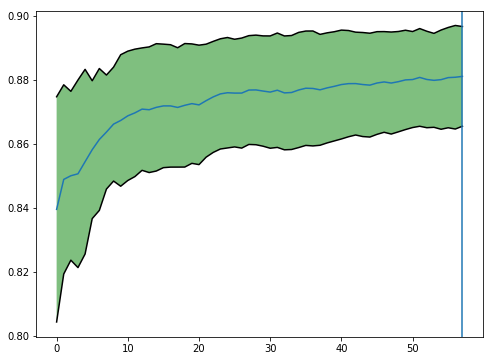

In [88]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

fig, ax = plt.subplots(figsize=(8, 6))

lower = [m - s for m, s in zip(hist['auc-mean'], hist['auc-stdv'])]
upper = [m + s for m, s in zip(hist['auc-mean'], hist['auc-stdv'])]
ax.plot(hist['auc-mean']);
ax.plot(lower, color='black');
ax.plot(upper, color='black');
ax.fill_between(x=list(range(len(lower))), y1=lower, y2=upper, facecolor='green', alpha=0.5);
ax.axvline(x=best_round);

Train on all of the training set.

In [48]:
# https://lightgbm.readthedocs.io/en/latest/Python-API.html#lightgbm.train
model = lgbm.train(
    params=params,
    train_set=train_set,
    num_boost_round=best_round,
    valid_names=('train'),
    verbose_eval=10
)

Make predictions.

In [56]:
submission['Survived'] = model.predict(X_test)
submission.head()

,PassengerId,Survived
0,892,0.051493
1,893,0.360317
2,894,0.072305
3,895,0.308944
4,896,0.517390
